In [1]:
corpus = ['king is a strong man', 
          'queen is a wise woman', 
          'boy is a young man',
          'girl is a young woman',
          'prince is a young king',
          'princess is a young queen',
          'man is strong', 
          'woman is pretty',
          'prince is a boy will be king',
          'princess is a girl will be queen']

In [2]:
print corpus

['king is a strong man', 'queen is a wise woman', 'boy is a young man', 'girl is a young woman', 'prince is a young king', 'princess is a young queen', 'man is strong', 'woman is pretty', 'prince is a boy will be king', 'princess is a girl will be queen']


In [7]:
def remove_stop_words(corpus):
    stop_words = ['is', 'a', 'will', 'be']
    results = []
    for text in corpus:
        tmp = text.split(' ')
        for stop_word in stop_words:
            if stop_word in tmp:
                tmp.remove(stop_word)
        results.append(" ".join(tmp))
    return results


In [8]:
corpus = remove_stop_words(corpus)
print corpus

['king strong man', 'queen wise woman', 'boy young man', 'girl young woman', 'prince young king', 'princess young queen', 'man strong', 'woman pretty', 'prince boy king', 'princess girl queen']


In [10]:
words = []
for text in corpus:
    for word in text.split(' '):
        words.append(word)
        
words = set(words)

words

{'boy',
 'girl',
 'king',
 'man',
 'pretty',
 'prince',
 'princess',
 'queen',
 'strong',
 'wise',
 'woman',
 'young'}

In [12]:
word2int = {}

for i,word in enumerate(words):
    word2int[word] = i
    
sentences = []
for sentence in corpus:
    sentences.append(sentence.split())
    
WINDOW_SIZE = 2

data = []
for sentence in sentences:
    for idx, word in enumerate(sentence):
        for neighbor in sentence[max(idx - WINDOW_SIZE, 0) : min(idx + WINDOW_SIZE, len(sentence)) + 1]:
            if neighbor != word:
                data.append([word, neighbor])
                

In [14]:
import pandas as pd
for text in corpus:
    print(text)
    
df = pd.DataFrame(data, columns = ['input', 'label'])

king strong man
queen wise woman
boy young man
girl young woman
prince young king
princess young queen
man strong
woman pretty
prince boy king
princess girl queen


In [15]:
df.head(10)


,input,label
0,king,strong
1,king,man
2,strong,king
3,strong,man
4,man,king
5,man,strong
6,queen,wise
7,queen,woman
8,wise,queen
9,wise,woman


In [16]:
df.shape

(52, 2)

In [17]:
word2int

{'boy': 3,
 'girl': 8,
 'king': 0,
 'man': 11,
 'pretty': 7,
 'prince': 10,
 'princess': 6,
 'queen': 4,
 'strong': 9,
 'wise': 2,
 'woman': 1,
 'young': 5}

In [19]:
import tensorflow as tf
import numpy as np

ONE_HOT_DIM = len(words)

def to_one_hot_encoding(data_point_index):
    one_hot_encoding = np.zeros(ONE_HOT_DIM)
    one_hot_encoding[data_point_index] = 1
    return one_hot_encoding

X = []
Y = []

for x,y in zip(df['input'], df['label']):
    X.append(to_one_hot_encoding(word2int[x]))
    Y.append(to_one_hot_encoding(word2int[y]))
    
X_train = np.asarray(X)
Y_train = np.asarray(Y)

x = tf.placeholder(tf.float32, shape = (None, ONE_HOT_DIM))
y_label = tf.placeholder(tf.float32, shape = (None, ONE_HOT_DIM))


EMBEDDING_DIM = 2 

# hidden layer: which represents word vector eventually
W1 = tf.Variable(tf.random_normal([ONE_HOT_DIM, EMBEDDING_DIM]))
b1 = tf.Variable(tf.random_normal([1])) #bias
hidden_layer = tf.add(tf.matmul(x,W1), b1)

# output layer
W2 = tf.Variable(tf.random_normal([EMBEDDING_DIM, ONE_HOT_DIM]))
b2 = tf.Variable(tf.random_normal([1]))
prediction = tf.nn.softmax(tf.add( tf.matmul(hidden_layer, W2), b2))

# loss function: cross entropy
loss = tf.reduce_mean(-tf.reduce_sum(y_label * tf.log(prediction), axis=[1]))

# training operation
train_op = tf.train.GradientDescentOptimizer(0.05).minimize(loss)


In [20]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init) 

iteration = 20000
for i in range(iteration):
    # input is X_train which is one hot encoded word
    # label is Y_train which is one hot encoded neighbor word
    sess.run(train_op, feed_dict={x: X_train, y_label: Y_train})
    if i % 3000 == 0:
        print('iteration '+str(i)+' loss is : ', sess.run(loss, feed_dict={x: X_train, y_label: Y_train}))


('iteration 0 loss is : ', 3.0957494)
('iteration 3000 loss is : ', 1.8716539)
('iteration 6000 loss is : ', 1.7924058)
('iteration 9000 loss is : ', 1.7545651)
('iteration 12000 loss is : ', 1.7361381)
('iteration 15000 loss is : ', 1.723689)
('iteration 18000 loss is : ', 1.7137774)


In [21]:
vectors = sess.run(W1 + b1)
print(vectors)


[[ 1.2558794   0.12048548]
 [-0.02488256  0.7829983 ]
 [-1.9292325   3.0078635 ]
 [ 1.2718619  -0.0320611 ]
 [-0.24236596  3.4461708 ]
 [-0.2919581  -0.35209095]
 [-0.32839382  0.87447584]
 [-1.5679945   5.2681737 ]
 [-0.4157002   3.0310373 ]
 [ 2.886013   -2.7646651 ]
 [ 6.0123663   0.75158525]
 [ 5.842494    1.0016268 ]]


In [22]:
w2v_df = pd.DataFrame(vectors, columns = ['x1', 'x2'])
w2v_df['word'] = words
w2v_df = w2v_df[['word', 'x1', 'x2']]
w2v_df


,word,x1,x2
0,king,1.255879,0.120485
1,woman,-0.024883,0.782998
2,wise,-1.929232,3.007864
3,boy,1.271862,-0.032061
4,queen,-0.242366,3.446171
5,young,-0.291958,-0.352091
6,princess,-0.328394,0.874476
7,pretty,-1.567994,5.268174
8,girl,-0.415700,3.031037
9,strong,2.886013,-2.764665


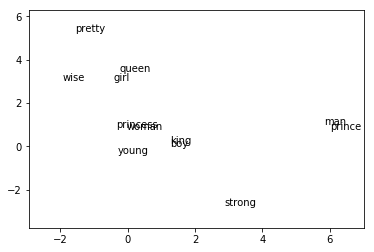

In [25]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

for word, x1, x2 in zip(w2v_df['word'], w2v_df['x1'], w2v_df['x2']):
    ax.annotate(word, (x1,x2 ))
    
PADDING = 1.0
x_axis_min = np.amin(vectors, axis=0)[0] - PADDING
y_axis_min = np.amin(vectors, axis=0)[1] - PADDING
x_axis_max = np.amax(vectors, axis=0)[0] + PADDING
y_axis_max = np.amax(vectors, axis=0)[1] + PADDING
 
plt.xlim(x_axis_min,x_axis_max)
plt.ylim(y_axis_min,y_axis_max)
plt.rcParams["figure.figsize"] = (10,10)

plt.show()


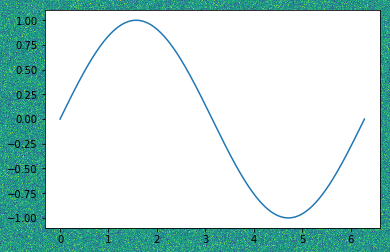